In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import geopandas as gpd
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
from input_configuration import base_year

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [3]:
pd.options.display.float_format = '{:0,.0f}'.format

# Boardings by Agency

In [4]:
df = pd.read_csv(os.path.join(relative_path,'transit','daily_boardings_by_agency.csv'),index_col=0)
df.loc['Region Total','boardings'] = df['boardings'].sum()
df = df.reset_index()
df.rename(columns={'agency_name': 'Agency', 'boardings': 'Boardings'}, inplace=True)
HTML(df.to_html(index=False))

Agency,Boardings
King County Metro,"397,919"
Sound Transit,"158,512"
Pierce Transit,"34,097"
Community Transit,"33,717"
Kitsap Transit,"14,844"
Washington Ferries,"12,361"
Everett Transit,"5,185"
Region Total,"656,635"


# Boardings by Service Type

In [5]:
df = pd.read_csv(os.path.join(relative_path,'transit','transit_line_results.csv'),index_col=0)
df['mode'] = df['mode'].map({'b': 'Local Bus','f': 'Ferry','r':'Light Rail','c':'Commuter Rail','p':'Ferry'})
df = df.groupby('mode').sum()[['boardings']]
df = df.reset_index()
df.rename(columns={'mode': 'Service Type', 'boardings': 'Boardings'}, inplace=True)
HTML(df.to_html(index=False))

Service Type,Boardings
Commuter Rail,"20,025"
Ferry,"17,760"
Light Rail,"70,358"
Local Bus,"558,792"


# High Capacity Transit (HCT)

In [6]:
# List of Stations
# Load transit stops file

#"The definition we have been using for the RTP is BRT, LRT, Commuter Rail, StreetCar and Ferry."
df = pd.read_csv(r'../../../inputs/scenario/networks/transit_stops.csv')
# Streetcar is coded as light rail
df['hct'] = 0
df.loc[df[['commuter_rail','light_rail','ferry','brt']].sum(axis=1) > 0,'hct'] = 1
df_hct = df[df['hct'] == 1]

In [7]:
# Map of Stations
# Load as a geodataframe
gdf_hct = gpd.GeoDataFrame(
    df_hct, geometry=gpd.points_from_xy(df_hct.x, df_hct.y))

crs = {'init' : 'EPSG:2285'}
gdf_hct.crs = crs

## HCT Station Location

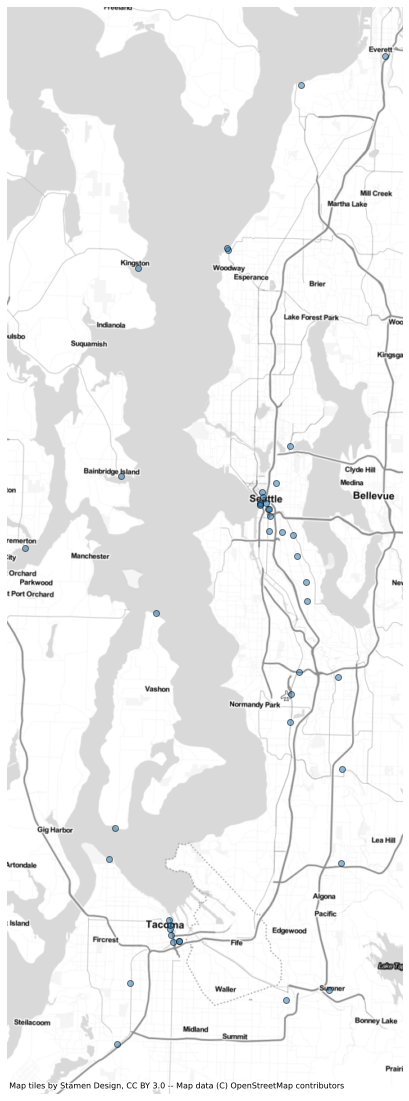

In [8]:
import contextily as ctx
ax = gdf_hct.plot(figsize=(20,20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=crs)
ax.set_axis_off()

In [9]:
# Export stops as a shapefile
gdf_hct.to_file(os.path.join(relative_path,'hct_stops.shp'))

C:\Users\Modeller\Anaconda3\envs\summary\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


## HCT Network

In [10]:
# df = pd.read_csv(r'..\..\..\outputs\transit\transit_line_results.csv')
df_segments = pd.read_csv(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_transit_segments.csv')
df = pd.read_csv(r'../../../inputs/scenario/networks/transit_stops.csv')
# Create a column that identifies HCT routes
df['hct'] = 0
df.loc[df[['commuter_rail','light_rail','ferry','brt']].sum(axis=1) > 0,'hct'] = 1
df_hct = df[df['hct'] == 1]
df_hct

def identify_hct_routes(df_segments, df_hct_stops):
    """Returns HCT routes as a list. HCT links are defined in the geodatbase based on the TransitType field.
       This field is not available on the network files so we use stop defintions, which are then linked to 
       transit segments. These segments are then associated with IJ network links. 
    """
    
    # Identify routes that have all stops flagged as HCT, using only segments with stops
    df_stop_segments = df_segments[df_segments['is_stop'] == 1]

    # Iterate through all transit lines and flag as an HCT route only if all 
    # stops on the line correspond to HCT stop locations - this avoids 
    # flagging non-HCT routes that share the same stop as HCT routes
    hct_routes = []
    for route_id in df_stop_segments['route_id'].unique():
        _df = df_stop_segments[df_stop_segments['route_id'] == route_id]
        if len(_df[_df['INode'].isin(df_hct['PSRCJunctID'])]) == len(_df):
            hct_routes.append(route_id)
            
    return hct_routes

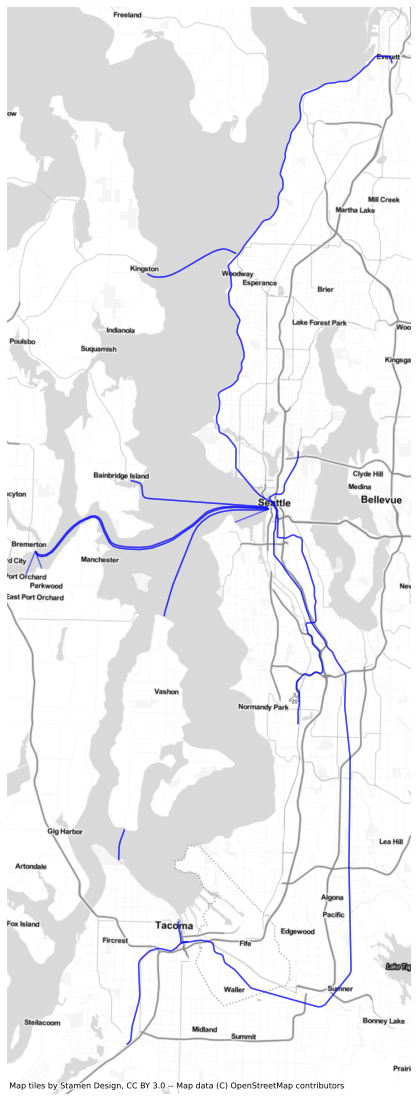

In [11]:
df_network = gpd.read_file(r'../../../inputs/scenario/networks/shapefiles/AM/AM_edges.shp')
hct_routes = identify_hct_routes(df_segments, df_hct)
hct_segments = df_segments[df_segments['route_id'].isin(hct_routes)]
hct_network = df_network[df_network['id'].isin(hct_segments['ij'])]
hct_network.crs = crs
ax = hct_network.plot(figsize=(10,20), alpha=0.5, edgecolor='b')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=crs)
ax.set_axis_off()

## Households Living Near HCT Stations
Within one quarter (0.25) or one half (0.5) miles of HCT station 

In [12]:
df_lu = pd.read_csv(r'..\..\..\inputs\scenario\landuse\parcels_urbansim.txt',
                   delim_whitespace=True)

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.XCOORD_P, df_lu.YCOORD_P))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///../../../inputs/db/soundcast_inputs.db')

In [13]:
df_lu = df_lu.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')

In [14]:
def calculate_buffer(gdf_lu, gdf_network, distance):
    
    # Buffer the HCT station gdf
    gdf_network['geometry'] = gdf_network.buffer(distance)

    gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)
    df = df_lu[df_lu['PARCELID'].isin(gdf_intersect['PARCELID'].unique())]

#     df = df.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')
    
    return df

In [15]:
def aggregate_parcels(df, col_dict, sum_field):
    results_df = pd.DataFrame()
    for col, name in col_dict.items():
        _df = df.groupby(col).sum()[[sum_field]]
        _df['group'] = name
        results_df = results_df.append(_df)
    results_df = results_df.reset_index()
    
    return results_df

In [16]:
df_025 = calculate_buffer(gdf_lu, gdf_hct, distance=5280.0/4)

In [17]:
df_050 = calculate_buffer(gdf_lu, gdf_hct, distance=5280.0/2)

In [18]:
pd.options.display.float_format = '{:0,.0f}'.format
col_dict = {'racial_geog_vs_reg_total': 'Race',
                      'poverty_geog_vs_reg_total': 'Poverty',
                      'elderly_geog_vs_reg_total': 'Elderly',
                      'youth_geog_vs_reg_total': 'Youth',
           'rg_proposed': 'Regional Geography',
            'CountyName': 'County',
            'GrowthCenterName': 'Regional Growth Center'
           }

hct_hh_df = pd.DataFrame()
df = aggregate_parcels(df_025, col_dict, 'HH_P')
df['distance'] = 0.25
hct_hh_df = hct_hh_df.append(df)
df = aggregate_parcels(df_050, col_dict, 'HH_P')
df['distance'] = 0.50
hct_hh_df = hct_hh_df.append(df)

In [19]:
pd.options.display.float_format = '{:0,.0f}'.format

### Counties
Total households within given distance of HCT stations by county

In [20]:
df = hct_hh_df[hct_hh_df['group'] == 'County']
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'County'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
HTML(df.to_html(index=False))

County,1/4 Mile,1/2 Mile
King,"20,014","103,060"
Kitsap,89,"3,992"
Pierce,"3,061","19,997"
Snohomish,395,"6,511"


### Regional Growth Centers

In [21]:
df = hct_hh_df[hct_hh_df['group'] == 'Regional Growth Center']
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Regional Growth Center'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
HTML(df.to_html(index=False))

Regional Growth Center,1/4 Mile,1/2 Mile
Auburn,311,650
Bremerton,46,"1,208"
Duwamish,0,362
Everett,17,"1,942"
Kent,334,721
Kent MIC,0,0
Lakewood,214,978
Not in RGC,"6,373","56,736"
Paine Field / Boeing Everett,0,0
Port of Tacoma,0,2


### Regional Geographies

In [22]:
df = hct_hh_df[hct_hh_df['group'] == 'Regional Geography']
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Regional Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
HTML(df.to_html(index=False))

Regional Geography,1/4 Mile,1/2 Mile
CitiesTowns,0,441
Core,"2,448","19,850"
HCT,681,"7,025"
Metro,"20,389","105,581"
Rural,41,415
UU,0,248


### Equity Geographies

In [23]:
# df = aggregate_parcels(df_lu, col_dict, 'HH_P')
df = hct_hh_df.copy()
df = df[df['index'] == 1]
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df.drop('index', axis=1, inplace=True)
df = df.pivot_table(index='group', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Equity Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
HTML(df.to_html(index=False))

Equity Geography,1/4 Mile,1/2 Mile
Elderly,"11,364","47,149"
Poverty,"20,509","98,071"
Race,"14,809","83,514"
Youth,"2,297","21,652"


# Jobs Near HCT Stations

In [24]:
col_dict = {'racial_geog_vs_reg_total': 'Race',
                      'poverty_geog_vs_reg_total': 'Poverty',
                      'elderly_geog_vs_reg_total': 'Elderly',
                      'youth_geog_vs_reg_total': 'Youth',
           'rg_proposed': 'Regional Geography',
            'CountyName': 'County',
            'GrowthCenterName': 'Regional Growth Center'
           }

hct_hh_df = pd.DataFrame()
df = aggregate_parcels(df_025, col_dict, 'EMPTOT_P')
df['distance'] = 0.25
hct_hh_df = hct_hh_df.append(df)
df = aggregate_parcels(df_050, col_dict, 'EMPTOT_P')
df['distance'] = 0.50
hct_hh_df = hct_hh_df.append(df)

In [25]:
pd.options.display.float_format = '{:0,.0f}'.format

### Counties

In [26]:
df = hct_hh_df[hct_hh_df['group'] == 'County']
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'County'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
HTML(df.to_html(index=False))

County,1/4 Mile,1/2 Mile
King,"175,323","428,389"
Kitsap,"1,390","14,846"
Pierce,"23,013","66,823"
Snohomish,"2,665","18,216"


### Regional Growth Centers

In [27]:
df = hct_hh_df[hct_hh_df['group'] == 'Regional Growth Center']
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Regional Growth Center'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
HTML(df.to_html(index=False))

Regional Growth Center,1/4 Mile,1/2 Mile
Auburn,"2,311","4,164"
Bremerton,"1,022","11,261"
Duwamish,"7,863","31,359"
Everett,"1,637","11,515"
Kent,"3,375","7,343"
Kent MIC,0,"1,248"
Lakewood,425,"1,453"
Not in RGC,"10,012","80,761"
Paine Field / Boeing Everett,0,0
Port of Tacoma,0,"2,180"


### Regional Geographies

In [28]:
df = hct_hh_df[hct_hh_df['group'] == 'Regional Geography']
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Regional Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
HTML(df.to_html(index=False))

Regional Geography,1/4 Mile,1/2 Mile
CitiesTowns,0,492
Core,"22,691","87,904"
HCT,"2,380","11,080"
Metro,"177,205","428,612"
Rural,115,120
UU,0,66


### Equity Geographies

In [29]:
# df = aggregate_parcels(df_lu, col_dict, 'HH_P')
df = hct_hh_df.copy()
df = df[df['index'] == 1]
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df.drop('index', axis=1, inplace=True)
df = df.pivot_table(index='group', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Equity Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
HTML(df.to_html(index=False))

Equity Geography,1/4 Mile,1/2 Mile
Elderly,"158,941","257,309"
Poverty,"168,835","444,526"
Race,"117,918","364,074"
Youth,"14,321","43,344"


# Boardings by Stops
by Equity Geographies

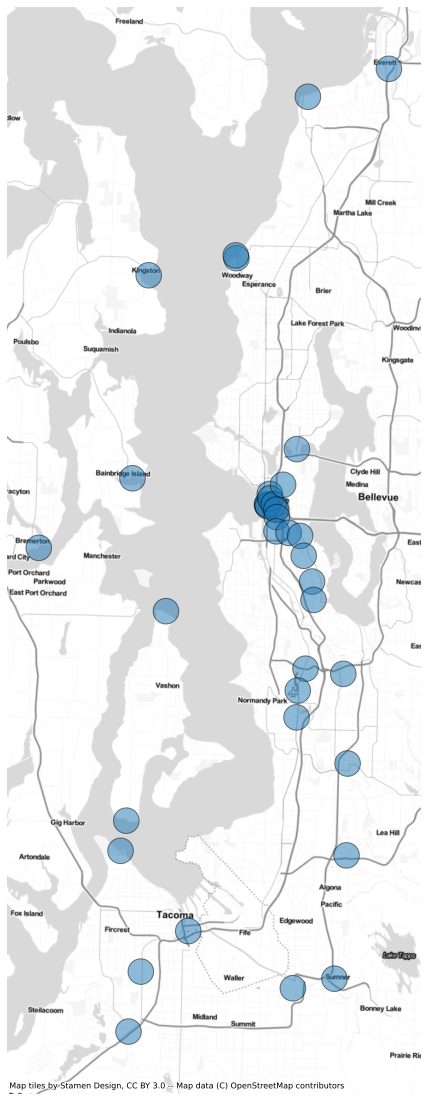

In [30]:
# Join boardings data with HCT stops file.
# Show magnitude of boardings
df = pd.read_csv(r'../../../outputs/transit/boardings_by_stop.csv')
# gdf_hct.plot()
df = gdf_hct.merge(df, left_on='PSRCJunctID', right_on='node_id')
# df.plot('total_boardings', figsize=(20,20), alpha=0.3)
ax = df.plot(markersize=df['total_boardings'], figsize=(30,20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=crs)
ax.set_axis_off()

# Transfers
Transfers between transit modes
- rows are the initial mode and columns are the mode transfered to

In [31]:
df = pd.read_csv(r'../../../outputs/transit/transit_transfers.csv')
for col in ['from_mode','to_mode']:
    df[col] = df[col].map({'b': 'Local Bus','f': 'Ferry','r':'Light Rail','c':'Commuter Rail','p':'Ferry'})
df.rename(columns={'boardings': 'Boardings'}, inplace=True)

In [32]:
_df = df.pivot_table(index='from_mode', columns='to_mode', values='Boardings', aggfunc='sum')
_df

to_mode,Commuter Rail,Ferry,Light Rail,Local Bus
from_mode,,,,
Commuter Rail,36,28,330,"10,364"
Ferry,38,"1,318",220,"7,111"
Light Rail,447,263,87,"30,508"
Local Bus,"9,620","6,792","26,885","131,167"


#### Transit Mode for Transfers to HCT Routes
e.g., rode local bus to HCT route

In [33]:
# Total number of transfers to HCT from transit modes
_df = df.groupby(['from_mode','to_mode']).sum()[['Boardings']].reset_index()
hct_modes = ['Commuter Rail','Ferry','Light Rail','Local Bus']
_df = _df[_df['to_mode'].isin(hct_modes)].groupby('from_mode').sum()[['Boardings']]
_df = _df.reset_index()
_df.groupby('from_mode').sum()[['Boardings']]

,Boardings
from_mode,
Commuter Rail,"10,758"
Ferry,"8,686"
Light Rail,"31,304"
Local Bus,"174,464"


#### Transit Mode for Transfers from HCT Routes
e.g., took local bus after using HCT route

In [34]:
# Total number of transfers to HCT from transit modes
_df = df.groupby(['from_mode','to_mode']).sum()[['Boardings']].reset_index()
hct_modes = ['Commuter Rail','Ferry','Light Rail','Local Bus']
_df = _df[_df['from_mode'].isin(hct_modes)].groupby('to_mode').sum()[['Boardings']]
_df = _df.reset_index()
_df.groupby('to_mode').sum()[['Boardings']]

,Boardings
to_mode,
Commuter Rail,"10,141"
Ferry,"8,400"
Light Rail,"27,521"
Local Bus,"179,150"


# Transit Access Mode
### Percent of Transit Trips Accessed by Walking

#### Region

In [35]:
pd.options.display.float_format = '{:0,.1%}'.format
df = pd.read_csv(r'../../../outputs/agg/dash/trip_mode_by_tour_mode.csv')
_df = df.copy()
pnr_transit_trips = _df[(_df['tmodetp'] == 'Park') & (_df['mode'] == 'Transit')]['trexpfac'].sum()
walk_transit_trips = _df[(_df['tmodetp'] == 'Transit') & (_df['mode'] == 'Transit')]['trexpfac'].sum()
reg_access = (walk_transit_trips/(walk_transit_trips+pnr_transit_trips))
pd.DataFrame([reg_access], columns=['% Transit trips Accessed by Walking'], index=['Region'])


,% Transit trips Accessed by Walking
Region,83.3%


#### Equity Geographies

In [36]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = df.copy()
results_df = pd.DataFrame()
for col in ['hh_disability','hh_elderly','hh_english','hh_poverty','hh_racial','hh_youth']:
    for suffix in ['_reg']:
        pnr_transit_trips = _df[(_df[col+suffix] == 1) & 
                                (_df['tmodetp'] == 'Park') &
                                (_df['mode'] == 'Transit')]['trexpfac'].sum()
        walk_transit_trips = _df[(_df[col+suffix] == 1) & 
                                  (_df['tmodetp'] == 'Transit') & 
                                  (_df['mode'] == 'Transit')]['trexpfac'].sum()
        if (pnr_transit_trips > 0) & (walk_transit_trips > 0):
            results_df.loc[col+suffix,'% Transit Trips Accessed by Walking'] = walk_transit_trips/(walk_transit_trips+pnr_transit_trips)
# results_df.rename(columns={'_reg':'> Regional Average', '_50': '> 50%'}, inplace=True)
results_df

,% Transit Trips Accessed by Walking
hh_disability_reg,83.5%
hh_elderly_reg,82.7%
hh_english_reg,84.7%
hh_poverty_reg,87.9%
hh_racial_reg,85.8%
hh_youth_reg,74.2%
